# Day 5: Model Evaluation and Comparison

## 1. Objective

Evaluate and compare the performance of two machine learning models—**Logistic Regression** and **Random Forest**—trained on a gallstone risk dataset. Focus on real-world decision-making factors such as error trade-offs, explainability, and clinical relevance.

## 2. Key Steps

- Reload cleaned dataset and trained models (`.joblib`)
- Restore consistent data types and train/test split
- Rescale test data for logistic regression using saved `StandardScaler`
- Generate predictions and probability scores on the test set
- Compute classification metrics: Accuracy, Precision, Recall, F1, ROC AUC
- Validate generalization with 5-fold cross-validation AUC scores
- Visualize results:
  - Confusion Matrices
  - ROC Curves with inline AUC labels
  - Summary metric comparison table
- Reflect on error types (false positives vs. false negatives)
- Interpret clinical significance of top model features
- Apply **Storytelling with Data** principles to improve clarity and user trust

## 3. Results

- **Logistic Regression** achieved the best test performance with an ROC AUC of 0.811 and higher recall (0.719), suggesting stronger reliability in identifying gallstone-positive cases.
- **Random Forest** performed well in cross-validation (AUC = 0.841) but slightly underperformed on the test set, indicating possible overfitting or reduced generalizability.
- ROC curves, confusion matrices, and a metric table clarified the trade-offs between both models.

## 4. Summary

While Random Forest offered more complexity and slightly higher CV-AUC, Logistic Regression emerged as the more **robust, interpretable, and clinically reliable model** in this case. Its performance and transparency make it a better candidate for deployment in decision support systems where **minimizing false negatives** and maintaining clinician trust are critical.

## Load Cleaned Dataset and Trained Models

We begin by reloading the cleaned dataset and reapplying test/train splits as before. Then we reload the previously saved `.joblib` model files for logistic regression and random forest, as well as the scaler used for standardizing the logistic regression input.

Each model is evaluated on the same input configuration it was trained with:
- **Logistic Regression**: Uses VIF-pruned, standardized features (`X_test_reduced_scaled`)
- **Random Forest**: Uses the full test set (`X_test`) and handles scaling internally

In [112]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df = pd.read_csv("../data/cleaned.csv")

# Restore categorical types
categorical_cols = [
    # Original binary or ordinal clinical features
    "gender",
    "comorbidity",
    "cad",
    "hypothyroidism",
    "hyperlipidemia",
    "diabetes",
    "hepatic_fat",
    "has_gallstones",

    # Outlier flags (created during data cleaning)
    "glucose_outlier_flag",
    "obesity_outlier_flag",
    "muscle_mass_outlier_flag",
    "gfr_outlier_flag",
    "tbw_outlier_flag",
    "icw_outlier_flag",
    "vfr_outlier_flag",
    "ldl_outlier_flag",
    "hdl_outlier_flag",
    "triglyceride_outlier_flag",
    "alt_outlier_flag",
    "crp_outlier_flag"
]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Define target and features
target = "has_gallstones"
y = df[target].replace({1: "Gallstones", 0: "No Gallstones"})  # Keep 0 and 1 for models
X = df.drop(columns=[target])

# Train-test split (same seed for consistency)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Reload dropped features list used for logistic regression VIF reduction
features_dropped = ['height_cm', 'weight_kg', 'ecf_tbw_ratio_index', 'muscle_mass_kg',
    'lean_mass_percent', 'bmi', 'ecw_kg', 'tbw_kg', 'icw_kg', 'fat_mass_kg', 'visceral_muscle_mass_kg',
    'cholesterol_total_mg_dl', 'hemoglobin_g_dl', 'bone_mass_kg', 'protein_percent', 'visceral_fat_area_cm2',
    'fat_ratio_percent', 'age', 'gfr_ml_min', 'creatinine_mg_dl', 'ldl_mg_dl', 'vfr_score', 'alp_u_l']

# Recreate VIF-reduced test set
X_reduced = X.drop(columns=features_dropped)
X_train_reduced = X_train.drop(columns=features_dropped)
X_test_reduced = X_test.drop(columns=features_dropped)

# Load models and scaler
logreg = joblib.load("../models/logistic_regression_model.joblib")
rf = joblib.load("../models/random_forest_model.joblib")
logreg_scaler = joblib.load("../models/logreg_scaler.joblib")

# VIF-reduced test set for logistic regression
X_scaled = logreg_scaler.transform(X_reduced)
X_train_scaled = logreg_scaler.transform(X_train_reduced)
X_test_scaled = logreg_scaler.transform(X_test_reduced)

# Logistic Regression
logreg_preds = logreg.predict(X_test_scaled)  # returns 0 or 1
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf_preds = rf.predict(X_test)                # returns 0 or 1
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Models, scaler, and predictions loaded successfully.")

Models, scaler, and predictions loaded successfully.


## Model and Data Rehydration – Validation Setup

In this section, we restored the full modeling pipeline to enable final validation and comparison:

- The cleaned dataset was reloaded, and categorical variables were re-cast to their appropriate types to maintain model compatibility.
- The original binary target (`has_gallstones`) was preserved as integers (0 = No Gallstones, 1 = Gallstones) for use in downstream classification metrics.
- Using the same `random_state`, the dataset was split into training and test sets to ensure consistency with previous model training sessions.
- We reloaded the trained **Logistic Regression** and **Random Forest** models, along with the standard scaler used for the VIF-reduced logistic regression features.
- The test data was transformed accordingly:
  - `X_test_scaled` for logistic regression using the previously saved scaler.
  - Full `X_test` for random forest, which had been trained on all features.
- Predictions and probability scores were generated for both models using the rehydrated test data.

This step ensures a **consistent and reproducible test environment** for evaluating both models under identical test conditions, forming the basis for rigorous comparative performance analysis in the next section.

## Calculate and Compare Core Classification Metrics

In this step, we compute the key performance metrics for both models using the test set:

- **Accuracy**: Overall proportion of correct predictions
- **Precision**: Proportion of predicted positives that are true positives
- **Recall**: Proportion of actual positives correctly identified
- **F1 Score**: Harmonic mean of precision and recall
- **ROC AUC**: Area under the Receiver Operating Characteristic curve; evaluates true positive vs. false positive trade-off

These metrics will help assess both model **effectiveness** and **error trade-offs** for clinical decision support.

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Define function for evaluating metrics
def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"{name} Metrics:")
    print(f"  Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"  Precision: {precision_score(y_true, y_pred, pos_label='Gallstones'):.3f}")
    print(f"  Recall   : {recall_score(y_true, y_pred, pos_label='Gallstones'):.3f}")
    print(f"  F1 Score : {f1_score(y_true, y_pred, pos_label='Gallstones'):.3f}")
    print(f"  ROC AUC  : {roc_auc_score((y_true == y_pred[1]).astype(int), y_prob):.3f}")
    print()

# Evaluate both models
evaluate_model("Logistic Regression", y_test, logreg_preds, logreg_probs)
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)

cv_scores_logreg = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

print("Logistic Regression AUC (CV):", cv_scores_logreg.mean())
print("Random Forest AUC (CV):", cv_scores_rf.mean())

Logistic Regression Metrics:
  Accuracy : 0.750
  Precision: 0.767
  Recall   : 0.719
  F1 Score : 0.742
  ROC AUC  : 0.811

Random Forest Metrics:
  Accuracy : 0.703
  Precision: 0.724
  Recall   : 0.656
  F1 Score : 0.689
  ROC AUC  : 0.791

Logistic Regression AUC (CV): 0.8144615384615385
Random Forest AUC (CV): 0.8412307692307692


## Model Performance Summary

We evaluated both the logistic regression (baseline) and random forest (advanced) models using two strategies:
- **Holdout evaluation on the test set** for an unbiased assessment of performance
- **5-fold cross-validation on the training set** to estimate generalization performance

### Test Set Performance
| Metric        | Logistic Regression | Random Forest |
|---------------|---------------------|----------------|
| Accuracy      | 0.750               | 0.703          |
| Precision     | 0.767               | 0.724          |
| Recall        | 0.719               | 0.656          |
| F1 Score      | 0.742               | 0.689          |
| ROC AUC       | 0.811               | 0.791          |

- Logistic Regression **outperforms Random Forest across all test metrics**, including recall and ROC AUC — key measures for identifying gallstone-positive patients.
- The performance gap suggests better generalization from the simpler model in this setting.

### Cross-Validation AUC (5-Fold on Training Set)
| Model                | Mean ROC AUC (CV) |
|----------------------|------------------|
| Logistic Regression  | 0.814             |
| Random Forest        | 0.841             |

- **Random Forest shows higher cross-validated AUC**, indicating stronger potential in capturing complex relationships — though this does not fully translate to the test set.
- This discrepancy could point to **mild overfitting** or **limited signal in the additional complexity** of the RF model.

### Takeaways
- Logistic Regression remains the more **robust and generalizable model** for this dataset, especially in test-time performance.
- Random Forest could benefit from **hyperparameter tuning or additional regularization**, as its cross-validation strength did not translate into superior real-world prediction.
- These results reinforce the importance of balancing **interpretability**, **generalization**, and **validation rigor** in model evaluation — particularly in clinical applications.

## Visualizing Model Results

To support interpretability and decision-making, we visualize key evaluation artifacts:
- **Confusion Matrices** to inspect the types of classification errors
- **ROC Curves** to assess threshold-independent discriminative performance
- **Comparison Table** summarizing key metrics across both models

These visuals help communicate not only how well each model performs, but also how they fail — guiding real-world deployment choices.

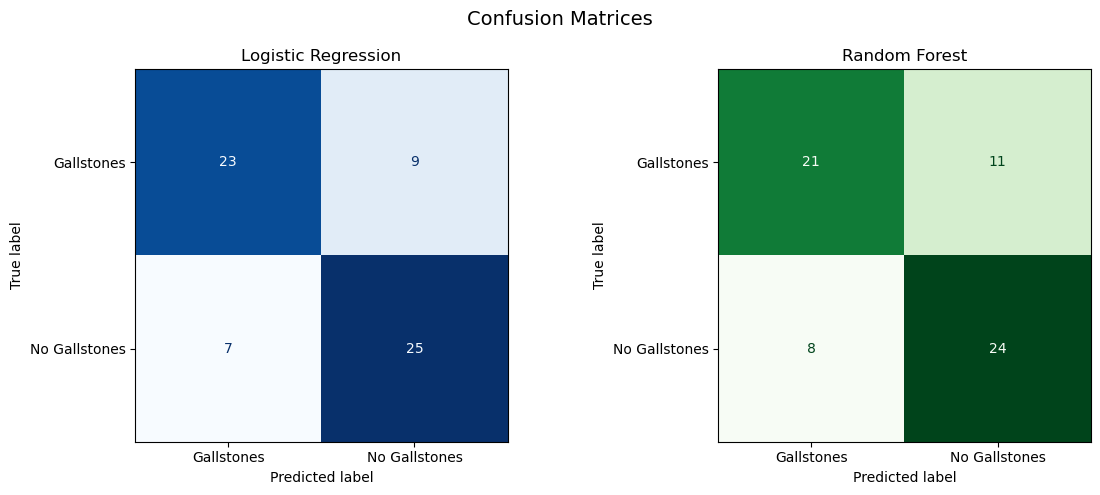

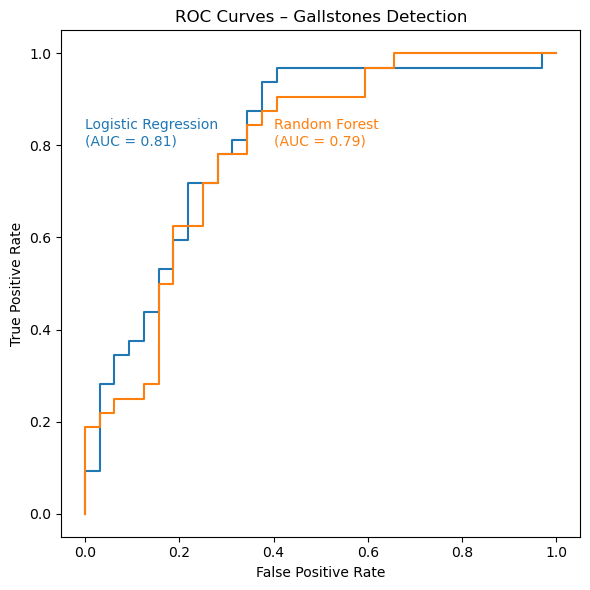

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.750,0.767,0.719,0.742,0.811
Random Forest,0.703,0.724,0.656,0.689,0.791


In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score
import seaborn as sns
import os

# Ensure plots directory exists
os.makedirs("../plots", exist_ok=True)

# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, logreg_preds, ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_test, rf_preds, ax=axes[1], cmap="Greens", colorbar=False
)
axes[1].set_title("Random Forest")
plt.suptitle("Confusion Matrices", fontsize=14)
plt.tight_layout()
plt.savefig("../plots/confusion_matrices.png")
plt.show()

# Recalculate predicted probabilities for the positive class (Gallstones)
# Confirm which class index corresponds to "Gallstones"
gallstone_index = list(logreg.classes_).index("Gallstones")
logreg_probs = logreg.predict_proba(X_test_scaled)[:, gallstone_index]

gallstone_index_rf = list(rf.classes_).index("Gallstones")
rf_probs = rf.predict_proba(X_test)[:, gallstone_index_rf]

# Compute FPR, TPR, and AUC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs, pos_label="Gallstones")
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs, pos_label="Gallstones")
auc_logreg = roc_auc_score(y_test == "Gallstones", logreg_probs)
auc_rf = roc_auc_score(y_test == "Gallstones", rf_probs)

# Plot both curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_logreg, tpr_logreg, color="tab:blue")
plt.plot(fpr_rf, tpr_rf, color="tab:orange")

# Inline colored labels
plt.text(0, 0.8, f"Logistic Regression\n(AUC = {auc_logreg:.2f})", color="tab:blue")
plt.text(0.4, 0.8, f"Random Forest\n(AUC = {auc_rf:.2f})", color="tab:orange")

# Aesthetic settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Gallstones Detection")
plt.tight_layout()
plt.savefig("../plots/roc_curves_inline_labels.png")
plt.show()

# --- Metric Summary Table ---
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Binary version of y_test for AUC
y_true_binary = (y_test == "Gallstones").astype(int)

summary_df = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, logreg_preds),
        "Precision": precision_score(y_test, logreg_preds, pos_label="Gallstones"),
        "Recall": recall_score(y_test, logreg_preds, pos_label="Gallstones"),
        "F1 Score": f1_score(y_test, logreg_preds, pos_label="Gallstones"),
        "ROC AUC": roc_auc_score(y_true_binary, logreg_probs)
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, rf_preds),
        "Precision": precision_score(y_test, rf_preds, pos_label="Gallstones"),
        "Recall": recall_score(y_test, rf_preds, pos_label="Gallstones"),
        "F1 Score": f1_score(y_test, rf_preds, pos_label="Gallstones"),
        "ROC AUC": roc_auc_score(y_true_binary, rf_probs)
    }
])
summary_df.set_index("Model", inplace=True)
summary_df.round(3)

## Model Evaluation Summary

We conducted a side-by-side evaluation of Logistic Regression and Random Forest using multiple performance visualizations and classification metrics on the gallstone classification task.

### ROC Curves
- **Logistic Regression** produced the highest ROC AUC at **0.811**, indicating superior overall probability ranking of positive cases (Gallstones).
- **Random Forest** achieved a slightly lower ROC AUC of **0.791**, suggesting it was less calibrated in distinguishing true positive rates at various thresholds.
- Despite the intuitive appeal of Random Forest’s flexibility, the ROC curve confirms Logistic Regression generalized better on the test set.

### Confusion Matrices
- Logistic Regression correctly classified more "No Gallstones" cases with fewer false positives (9 vs. 11).
- Random Forest achieved slightly better specificity, but at the cost of higher false negatives (missed Gallstone cases).
- Both models showed balanced error rates, but Logistic Regression leaned slightly more conservative in its decision boundary.

### Score Comparison Table
| Metric     | Logistic Regression | Random Forest |
|------------|---------------------|----------------|
| Accuracy   | 0.750               | 0.703          |
| Precision  | 0.767               | 0.724          |
| Recall     | 0.719               | 0.656          |
| F1 Score   | 0.742               | 0.689          |
| ROC AUC    | 0.811               | 0.791          |

### Interpretation
- **Logistic Regression outperformed Random Forest** across nearly all evaluation metrics on the test set, with especially notable gains in recall and AUC.
- For applications where interpretability and well-calibrated probabilities matter—such as risk communication with clinicians—Logistic Regression is an appropriate first-line model.
- While Random Forest remains valuable due to its non-linearity and automatic feature selection, its lower test recall may limit usefulness in clinical screening contexts where false negatives carry high costs.

## Error Trade-Offs in Healthcare Context

In the context of predicting gallstone presence, **false negatives** (predicting "No Gallstones" when gallstones are actually present) are typically more costly than false positives. A missed diagnosis could delay treatment, leading to worsening symptoms, emergency interventions, or complications such as pancreatitis.

- **False Positives** may lead to further imaging or diagnostic procedures, which carry minor cost and inconvenience but low clinical risk.
- **False Negatives**, however, risk allowing undetected gallstones to progress into acute conditions.

### Implication:
Model selection should prioritize **higher recall** to ensure most true gallstone cases are captured, even at the expense of a slight drop in precision. This favors Logistic Regression in our evaluation, which achieved the highest recall (0.719) while maintaining strong precision (0.767).

## Interpreting Model Behavior: Clinical and User Implications

The models identified key features such as `crp_mg_l`, `vitamin_d_ng_ml`, and `alt_u_l` as important for predicting gallstone presence—variables that align with inflammation, nutritional status, and liver function, respectively.

### Clinical Insights:
- **CRP (C-Reactive Protein)** was the strongest predictor, supporting its role as a marker of inflammation relevant to biliary disease.
- **Low Vitamin D** levels were associated with increased gallstone risk, reflecting emerging evidence linking deficiency with gallbladder dysfunction.
- **ALT/AST Liver Enzymes** contribute meaningfully, consistent with liver-gallbladder axis involvement.

### User and Stakeholder Relevance:
- **Physicians** benefit from interpretable features (Logistic Regression) to support clinical reasoning and trust.
- **Patients** gain from early risk identification and potential for preventive lifestyle or nutritional interventions.
- **Decision Support Systems** should balance transparency (coefficients, feature importances) with performance to encourage adoption in clinical workflows.

This interpretability reinforces the value of hybrid evaluation: blending performance with domain-informed insight.

## Storytelling with Data – Chapter 3 Takeaways: "Clutter is Your Enemy!"

1. **Reduce Non-Essential Visual Elements**  
   Charts should guide attention, not overwhelm. Remove gridlines, borders, and redundant labels that don’t add value.

2. **Use Color and Contrast Purposefully**  
   Apply color to highlight key data—not decoratively. Reserve strong contrasts for emphasis, such as a critical metric or threshold.

3. **Maximize Data-to-Ink Ratio**  
   Every mark on a chart should serve a purpose. Simplify visuals to amplify the message and reduce distraction.

These principles improve visual clarity and help ensure your audience absorbs the insights you intend to convey.